In [ ]:
!pip install torch numpy matplotlib tqdm 

In [3]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import numpy as np
import random


In [4]:
# 💻 Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [5]:
# 📊 Data Transformations and Loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 🧪 Use only 1,000 samples
subset = Subset(dataset, range(1000))
train_size = int(0.8 * len(subset))
val_size = len(subset) - train_size
train_subset, val_subset = random_split(subset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32)


100%|██████████| 170M/170M [03:24<00:00, 835kB/s]    


In [6]:
# 🧠 CNN Model Definition
class SimpleCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [32, 15, 15]
        x = self.pool(F.relu(self.conv2(x)))   # [64, 6, 6]
        x = x.view(-1, 64 * 6 * 6)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [7]:
# ⚙️ Hyperparameters
learning_rate = 0.001
num_epochs = 100
dropout = 0.4
optimizer_type = 'adam'  # or 'sgd'


In [8]:
# 📦 Model, Loss, Optimizer
model = SimpleCNN(dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) if optimizer_type == 'adam' \
            else optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [9]:
# 🏋️ Training + Validation
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    train_acc.append(acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc.append(100 * correct / total)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")


Epoch 1/100, Train Acc: 13.75%, Val Acc: 21.50%
Epoch 2/100, Train Acc: 23.62%, Val Acc: 32.00%
Epoch 3/100, Train Acc: 32.25%, Val Acc: 35.50%
Epoch 4/100, Train Acc: 37.50%, Val Acc: 36.50%
Epoch 5/100, Train Acc: 38.12%, Val Acc: 40.50%
Epoch 6/100, Train Acc: 42.38%, Val Acc: 37.50%
Epoch 7/100, Train Acc: 46.12%, Val Acc: 42.50%
Epoch 8/100, Train Acc: 49.88%, Val Acc: 42.50%
Epoch 9/100, Train Acc: 55.50%, Val Acc: 39.50%
Epoch 10/100, Train Acc: 55.00%, Val Acc: 37.00%
Epoch 11/100, Train Acc: 60.88%, Val Acc: 40.00%
Epoch 12/100, Train Acc: 60.00%, Val Acc: 38.00%
Epoch 13/100, Train Acc: 66.62%, Val Acc: 44.50%
Epoch 14/100, Train Acc: 64.88%, Val Acc: 38.00%
Epoch 15/100, Train Acc: 68.75%, Val Acc: 43.00%
Epoch 16/100, Train Acc: 73.12%, Val Acc: 44.00%
Epoch 17/100, Train Acc: 75.88%, Val Acc: 41.00%
Epoch 18/100, Train Acc: 77.38%, Val Acc: 42.50%
Epoch 19/100, Train Acc: 79.12%, Val Acc: 41.00%
Epoch 20/100, Train Acc: 81.25%, Val Acc: 42.00%
Epoch 21/100, Train Acc: 81.6

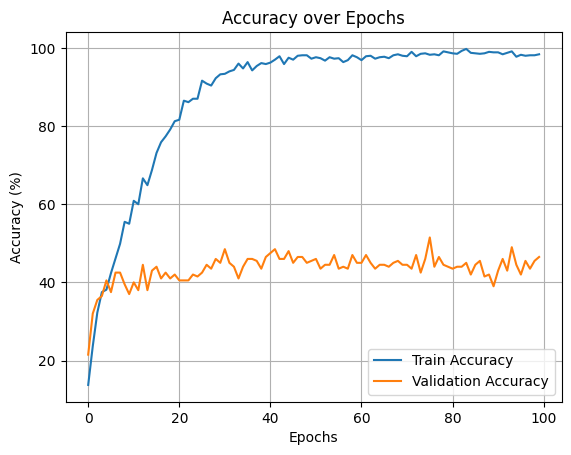

In [10]:
# 📈 Accuracy Plot
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


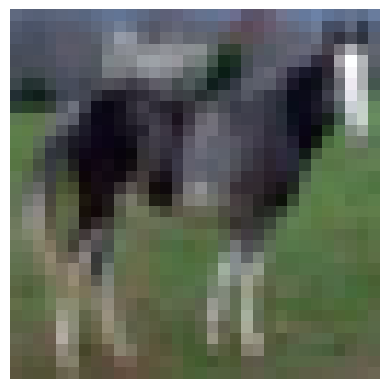

Actual: horse | Predicted: deer


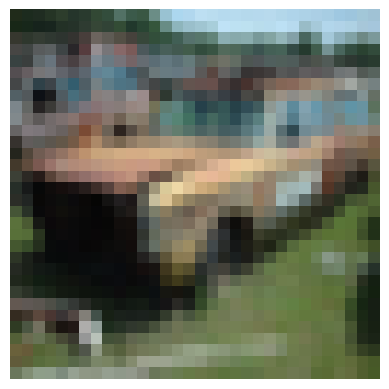

Actual: automobile | Predicted: frog


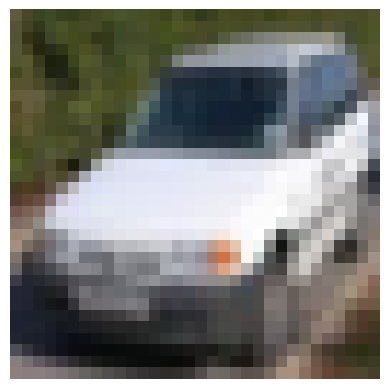

Actual: automobile | Predicted: automobile


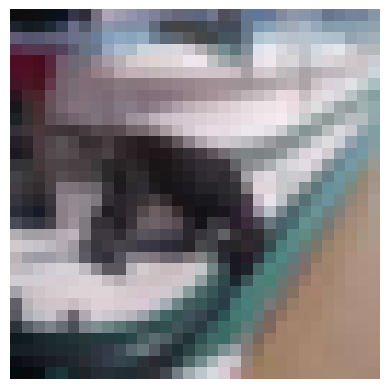

Actual: ship | Predicted: horse


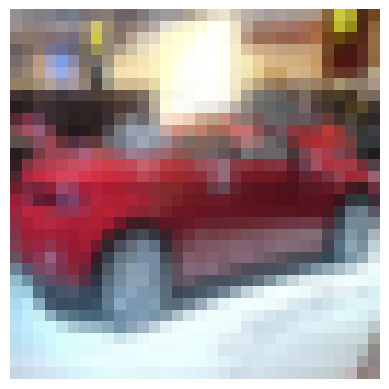

Actual: automobile | Predicted: bird


In [11]:
# 🖼️ Show Predictions
classes = dataset.classes

def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Show a few predictions
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

for i in range(5):
    imshow(images[i].cpu())
    print(f"Actual: {classes[labels[i]]} | Predicted: {classes[preds[i]]}")
